This is the solution to Fervo Energy Interview video timeseries problem

In [1]:
!sudo apt -q install tesseract-ocr
!pip -q install pytesseract

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (1,950 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Di

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import cv2
import os
from PIL import Image
import pytesseract
from datetime import datetime
import argparse
from ipywidgets import Video, Image
from IPython.display import display
import base64
import multiprocessing
from functools import partial
import timeit

number_of_processes = 100

In [3]:
## Define the files to be processed
zoom_video_file_name = "Test_Video.mp4"

In [4]:
# Display the video files
video = Video.from_file(zoom_video_file_name)
video

Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00mp41isom\x00\x00\x00(uuid\\\xa7\x08\xfb2\x8eB\x05\xa8ae\…

In [5]:
# The helper function for text extract from frames
def getText(img):
    HSV_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(HSV_img)
    #v = HSV_img[:, :, 2]
    v = cv2.GaussianBlur(v, (1,1), 0)
    thresh = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(1, 2))
    thresh = cv2.dilate(thresh, kernel)
    txt = pytesseract.image_to_string(thresh) #, config="--psm 6 digits")
    return txt

def get2Text(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    text = pytesseract.image_to_string(thresh, lang='eng')
    return text

In [6]:
cap = cv2.VideoCapture(zoom_video_file_name)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(fps)
cap.release()

10


In [7]:
def extract_frame_cpu(video_file, frame_number):

    cap = cv2.VideoCapture(video_file)
    if not cap.isOpened():
      print("Error: Could not open video.")
      return

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        text = get2Text(frame).split()
        data_pt = [datetime.strptime(text[0] + ' ' + text[1], '%H:%M:%S %p').time(), float(text[2])]
        return data_pt
    cap.release()
    return None

def video2text(video_file, use_gpu, fps, total_frames):

    cap = cv2.VideoCapture(video_file)
    if not cap.isOpened():
      print("Error: Could not open video.")
      return

    if use_gpu:
       timeseries = []
       frame_count = 0
       while cap.isOpened():
          cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
          ret, frame = cap.read()
          if ret:
              frame_count += fps
              text = get2Text(frame).split()
              timeseries.append([datetime.strptime(text[0] + ' ' + text[1], '%H:%M:%S %p').time(), float(text[2])])
          else:
              break
       cap.release()
    else:

       #ret, frame = cap.read()
       num_processes = multiprocessing.cpu_count()
       print(num_processes)
       #if ret:
       with multiprocessing.Pool(processes=num_processes) as pool:
          partial_extract_frame_cpu = partial(extract_frame_cpu, video_file)
          frames = pool.map(partial_extract_frame_cpu, range(0,total_frames,fps))

       timeseries = frames

    return timeseries

In [8]:
starttime = timeit.default_timer()
data = video2text(zoom_video_file_name, True, fps, total_frames)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 158.22591228800002


In [9]:
df = pd.DataFrame(data, columns=['Time stamp', 'Data'])
df.head()

,Time stamp,Data
0,11:22:38,371.49
1,11:22:39,377.05
2,11:22:40,364.08
3,11:22:41,374.45
4,11:22:42,383.69


<Axes: xlabel='Time stamp'>

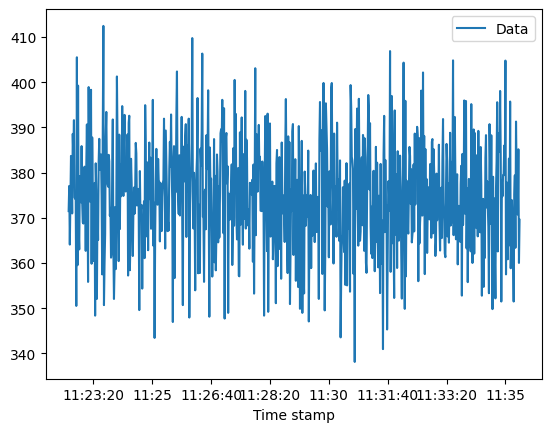

In [10]:
df.plot(x='Time stamp', y='Data')